In [1]:
'''
v0.1
This model preoduced a MSSSIM score of 0.86 on validation.
In this we attempt to improve the model.
'''

'\nv0.1\nThis model preoduced a MSSSIM score of 0.86 on validation.\nIn this we attempt to improve the model.\n'

In [2]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
from zipfile import ZipFile
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
%matplotlib inline
import torchvision
import zipfile
from IPython import display
from torch.autograd import Function
!git clone https://github.com/jorge-pessoa/pytorch-msssim
os.chdir('pytorch-msssim')
!python setup.py install
os.chdir('../')
import pytorch_msssim

Cloning into 'pytorch-msssim'...
remote: Enumerating objects: 132, done.
remote: Total 132 (delta 0), reused 0 (delta 0), pack-reused 132
Receiving objects: 100% (132/132), 1.23 MiB | 719.00 KiB/s, done.
Resolving deltas: 100% (57/57), done.
running install
running build
running build_py
creating build
creating build/lib
creating build/lib/pytorch_msssim
copying pytorch_msssim/__init__.py -> build/lib/pytorch_msssim
running install_lib
creating /opt/conda/lib/python3.6/site-packages/pytorch_msssim
copying build/lib/pytorch_msssim/__init__.py -> /opt/conda/lib/python3.6/site-packages/pytorch_msssim
byte-compiling /opt/conda/lib/python3.6/site-packages/pytorch_msssim/__init__.py to __init__.cpython-36.pyc
running install_egg_info
Writing /opt/conda/lib/python3.6/site-packages/pytorch_msssim-0.1-py3.6.egg-info


In [3]:
class imgDataset(Dataset):
    def __init__(self,path = '../input',indices=None):
        self.files = []
        for r, d, f in os.walk(path):
            for file in f:
                if '.png' in file:
                    self.files.append(os.path.join(r, file))
        if indices!=None:
            files2 = self.files
            self.files = []
            for i in range(len(files2)):
                self.files.append(files2[i])

    def __getitem__(self,idx):
        img = Image.open(self.files[idx])
        return self.transform(img)
    def __len__(self):
        return len(self.files)
    def transform(self,img):
        if random.random()>0.3:
            angle = random.randint(-60, 60)
            img = TF.rotate(img,angle)
        width, height = img.size
        dw = 32 - (width%32)
        dh = 32 - (height%32)
        img = TF.pad(img,(dw,dh,0,0))
        return TF.to_tensor(img)

In [4]:

class SignFunction(Function):
    def __init__(self):
        super(SignFunction,self).__init__()
    @staticmethod
    def forward(ctx,input, is_training=True):
        if is_training:
            prob = input.new(input.size()).uniform_()
            x = input.clone()
            x[(1 - input) / 2 <= prob] = 1
            x[(1 - input) / 2 > prob] = -1
            return x
        else:
            return input.sign()
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None
        
class Sign(nn.Module):
    def __init__(self):
        super(Sign, self).__init__()
    def forward(self,x):
        return SignFunction.apply(x, self.training)
class Binarizer(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Binarizer,self).__init__()
        self.sign = Sign()
        self.conv1 = nn.Conv2d(in_channels, out_channels,kernel_size=1,bias=False)
    def forward(self,x):
        x = self.conv1(x)
        x =  F.tanh(x)
        return self.sign(x)
        

In [5]:
class autoencoder(nn.Module):
  def __init__(self):
    super(autoencoder,self).__init__()
    self.enc = nn.Sequential(nn.Conv2d(3,32,8,stride=4,padding=2),
                            nn.ReLU(),
                            nn.BatchNorm2d(32),
                            nn.Conv2d(32,64,2,stride=2),
                            nn.ReLU(),
                            nn.BatchNorm2d(64),
#                             nn.Conv2d(32,128,6,stride=4,padding=1),
#                             nn.ReLU(),
#                             nn.BatchNorm2d(128),
#                             nn.Conv2d(128,128,3,stride=1,padding=1),
#                             nn.Sigmoid()
                            )
    self.dec = nn.Sequential(nn.ConvTranspose2d(128,32,8,stride=4, padding=2),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.ConvTranspose2d(32,3,2,2),
                            nn.BatchNorm2d(3),
                            nn.ReLU(),
#                             nn.ConvTranspose2d(64,32,2,2),
#                             nn.BatchNorm2d(32),
#                             nn.Conv2d(32,32,3,stride=1,padding=1),
#                             nn.BatchNorm2d(32),
#                             nn.ConvTranspose2d(32,3,2,2),
#                             nn.Sigmoid()
                            )
    self.binarizer = Binarizer(64,128)
  def forward(self,x):
    
    x = self.enc(x)
    x = self.binarizer(x)
#     print(x.shape)
    x = self.dec(x)
#     x = (x+1)*255
#     x.round_()
    return x
    

In [6]:
batch_size = 1
ds = imgDataset()
validation_split = 0.1
shuffle_dataset = True
random_seed= 42
# Creating data indices for training and validation splits:
dataset_size = len(ds)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]


# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(ds,batch_size=batch_size,sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size,sampler=validation_sampler)

In [7]:
model=autoencoder().float()
criterion =  nn.SmoothL1Loss()
msssim = None
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,80,100], gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()

In [8]:
def train(epoch=1,model=None,optimizer=None,criterion=None,batch_size=None,history=None,train_loader=None,exp_lr_scheduler=None,validation_loader=None):
  while epoch<=stop_epoch:
    total_loss = 0
    total_accuracy = 0
    model.train()
    exp_lr_scheduler.step()
    print('Epoch: {}\tLR: {:.5f}'.format(epoch,exp_lr_scheduler.get_lr()[0]))
    for batch_idx, data in enumerate(train_loader):
      target = data
      if torch.cuda.is_available():
        data = data.cuda()
        target = target.cuda()
      # forward
      output = model(data)
      # backward + optimize
      loss = criterion(output, target)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # print statistics
      total_loss+=loss
#       print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.5f}'.format(epoch, (batch_idx + 1) * len(data), len(train_indices),100*(batch_idx + 1)* len(data) / len(train_indices), loss))
    print('Train Loss: \t'+str(total_loss*batch_size/len(train_indices)))
    vloss, vaccuracy = validate(model,criterion,validation_loader)
    history['train_losses'].append((total_loss*batch_size)/len(train_indices))
    history['val_losses'].append((vloss*batch_size)/len(val_indices))
    history['epoch_data'].append(epoch)
#     visualize()
    epoch=1+epoch

In [9]:
def validate(model,criterion,validation_loader):
  total_loss = 0
  total_acc = 0
  model.train()
  for batch_idx, data in enumerate(validation_loader):
    target = data
    if torch.cuda.is_available():
      data = data.cuda()
      target = target.cuda()
    output = model(data)
    loss = criterion(output, target).item()
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    total_loss+=loss
    accuracy = 0
    total_acc+=accuracy
  return total_loss,total_acc
def visualize(history):
  plt.figure(figsize=(15,7))
  plt.plot(history['epoch_data'], history['train_losses'],label="Train Loss {:.5f}".format(history['train_losses'][-1]))
  plt.plot(history['epoch_data'], history['val_losses'], label="Validation Loss {:.5f}".format(history['val_losses'][-1]))
#   plt.plot(history['epoch_data'], history['train_accuracy'],label="Train Accuracy {:.5f}".format(history['train_accuracy'][-1]))
#   plt.plot(history['epoch_data'], history['val_accuracy'], label="Validation Accuracy {:.5f}".format(history['val_accuracy'][-1]))
  display.clear_output(wait=False)
  plt.legend()
  plt.show()

In [10]:
history = {
    'train_losses':[],
    'val_losses' :[],
    'epoch_data' : []
}
stop_epoch = 2
start = time.time()
train(model=model,optimizer=optimizer,criterion=criterion,batch_size=1,history=history,train_loader=train_loader,validation_loader=validation_loader,exp_lr_scheduler=exp_lr_scheduler)
end = time.time()
print(end-start)

Epoch: 1	LR: 0.10000
Train Loss: 	tensor(0.0179, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2	LR: 0.10000
Train Loss: 	tensor(0.0141, device='cuda:0', grad_fn=<DivBackward0>)
911.5290200710297


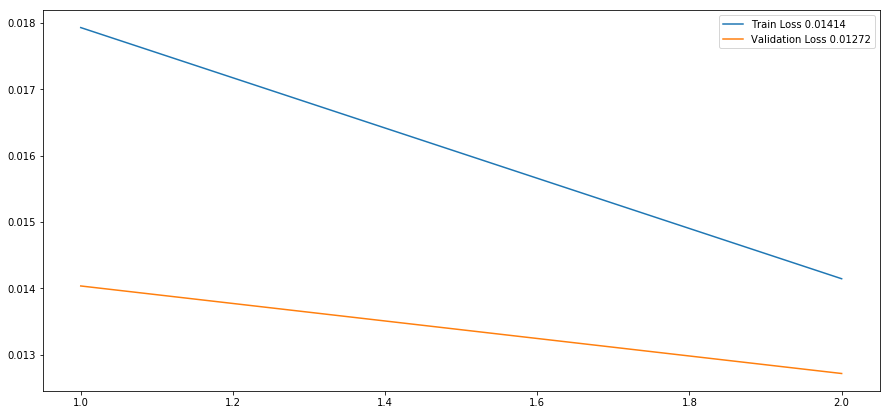

In [11]:
visualize(history)

In [12]:
torch.save(model.state_dict(),'model101.pt')

In [13]:
def save_checkpoint(state,filename):
    torch.save(state, filename)

In [14]:
save_checkpoint({
            'epoch': history['epoch_data'][-1] + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, 'train_state101.tar')

In [15]:
!ls

__notebook__.ipynb  model101.pt     train_state101.tar
__output__.json     pytorch-msssim


## Performance Measurement

In [16]:
def display_(x):
    if type(x) is tuple:
        img,out = x
        fig, axes = plt.subplots(ncols=1,nrows=2,figsize=(18,30))
        axes.ravel()[0].imshow(img)
        axes.ravel()[0].set_title('Original')
        axes.ravel()[1].imshow(out)
        axes.ravel()[1].set_title('After Compression')
        plt.show()
    else:
        plt.imshow(x)
        
def evaluate(ds,idx, showImages = False):
    model.eval()
    x = ds[idx]
    iimg = TF.to_pil_image(x)
    x=x.unsqueeze(0).cuda()
    y = model(x)
    oimg = TF.to_pil_image(y.squeeze(0).cpu().detach())
    score = (pytorch_msssim.msssim(x, y).item())
#     print("MSSSIM score is {:.5f}".format(score))
    if showImages:
        display_((iimg,oimg))
    return score

In [17]:
vds = imgDataset(indices=val_indices)
total_score=0
for i in range(0,len(vds)):
    total_score += evaluate(vds,i)
print('Average MSSSIM on validation is {:.5f}'.format(total_score/len(vds)))

Average MSSSIM on validation is 0.71989


In [18]:
import shutil
shutil.rmtree('pytorch-msssim')